<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [3]:
pip install pandas-profiling

     |████████████████████████████████| 262 kB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 709 kB 58.7 MB/s eta 0:00:01
     |████████████████████████████████| 4.7 MB 63.8 MB/s eta 0:00:01
     |████████████████████████████████| 102 kB 14.0 MB/s ta 0:00:01
     |████████████████████████████████| 2.0 MB 55.1 MB/s eta 0:00:01
     |████████████████████████████████| 296 kB 84.6 MB/s eta 0:00:01
     |████████████████████████████████| 6.9 MB 46.8 MB/s eta 0:00:01
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27085 sha256=a92be8b2893dad42179229caf36479a1830f24091d80259936f94cdab6f851b5
  Stored in directory: /home/jovyan/.cache/pip/wheels/1d/05/04/c6d7d3b66539d9e659ac6dfe81e2d0fd4c1a8316cc5a403300
Successfully built htmlmin
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd 
import warnings
import pandas_profiling
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils import shuffle

In [8]:
warnings.filterwarnings("ignore")

In [7]:
df = pd.read_csv('/datasets/Churn.csv', index_col=0)


In [5]:
pandas_profiling.ProfileReport(df)

Есть 909 пропущенных значений в столбце Tenure (сколько лет человек является клиентом банка).

In [9]:
#удалим колонки с id и фамилией, они не нужны для прогнозирования
df = df.drop(columns=['CustomerId', 'Surname'], axis=1)


## Исследование задачи

In [10]:
df.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [11]:
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
RowNumber,,,,,,,,,,,,
1,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
2,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
3,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
4,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
5,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


In [12]:
df_ohe['Tenure'].isna().sum()
df_ohe['Tenure'].value_counts()
#неизвестно, откуда взялись эти пропуски, заполним случайными числами от 0 до 10 
random = np.random.randint(0, 10, size=df_ohe['Tenure'].isna().sum())
df_ohe.loc[df_ohe['Tenure'].isna(), 'Tenure']=random

In [13]:
df_ohe.isna().sum()
#пропущенных значений не осталось 

CreditScore          0
Age                  0
Tenure               0
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
Geography_Germany    0
Geography_Spain      0
Gender_Male          0
dtype: int64

In [14]:
#создадим список с числовыми столбцами
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [15]:
corr = df_ohe.loc[:,numeric].corr()

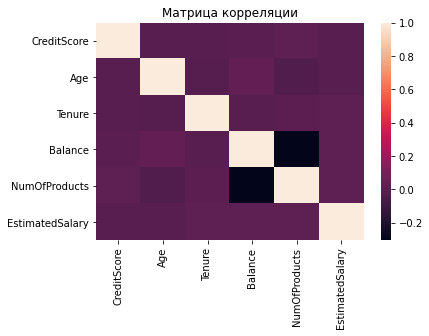

In [16]:
#построим хитмэп матрицы корреляции
sns.heatmap(corr)
plt.title('Матрица корреляции')
plt.show()


Корреляции между числовыми столбцами практически нет. Самое большое значение 0.3 между балансом и кол-вом продуктов. 

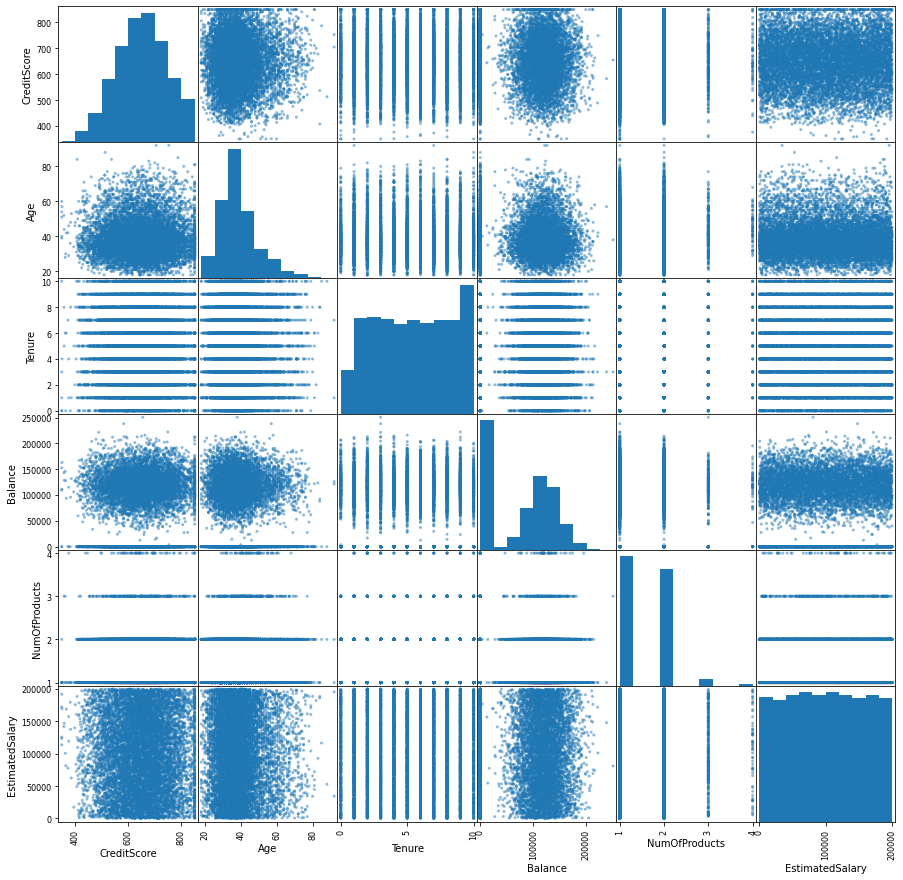

In [17]:
#построим скаттерплоты, изучим взаимосвязи
pd.plotting.scatter_matrix(df_ohe.loc[:,numeric], figsize=[15, 15]);

Ничего аномального на графиках не наблюдается. 

In [15]:
df_ohe[numeric].describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.959100,76485.889288,1.530200,100090.239881
std,96.653299,10.487806,2.894627,62397.405202,0.581654,57510.492818
min,350.000000,18.000000,0.000000,0.000000,1.000000,11.580000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,51002.110000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,100193.915000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,149388.247500
max,850.000000,92.000000,10.000000,250898.090000,4.000000,199992.480000


In [16]:
pandas_profiling.ProfileReport(df_ohe)

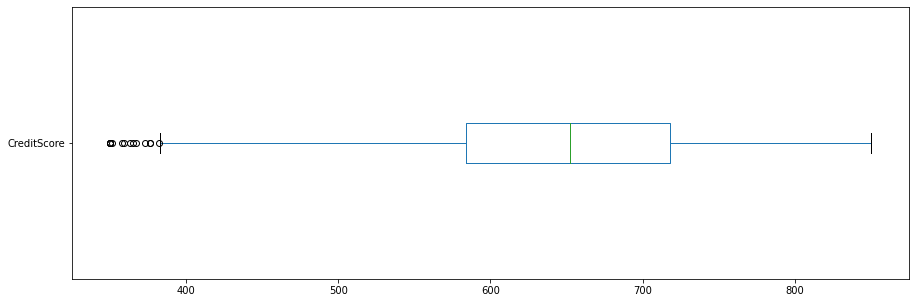

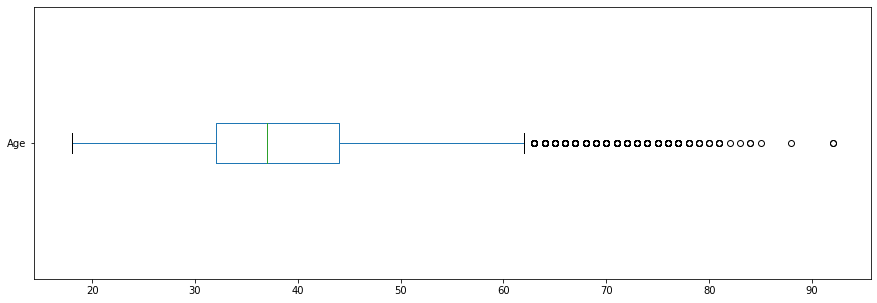

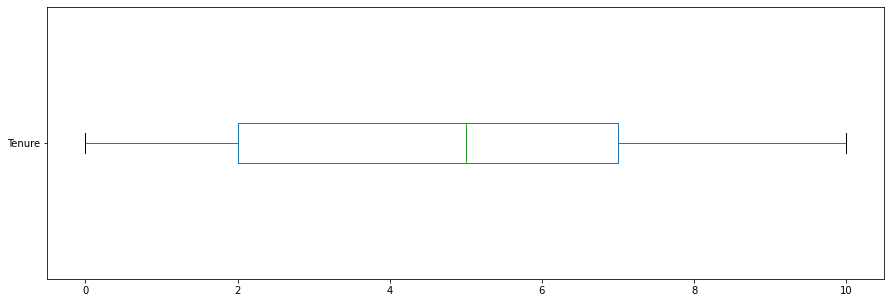

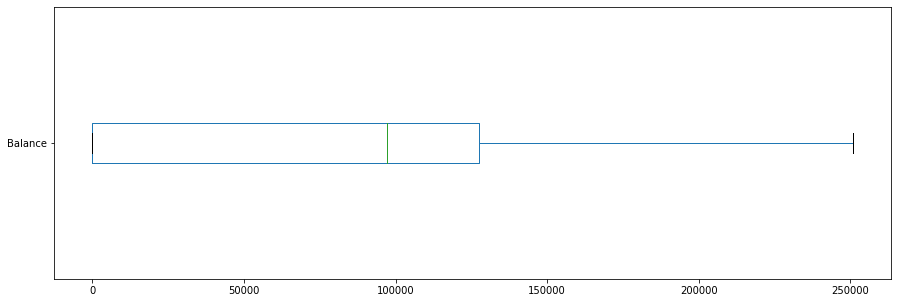

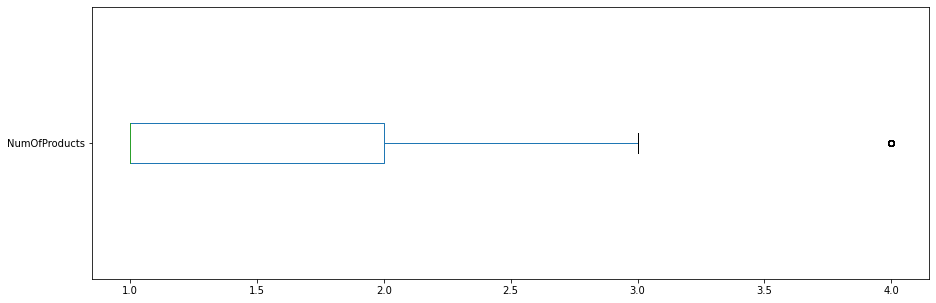

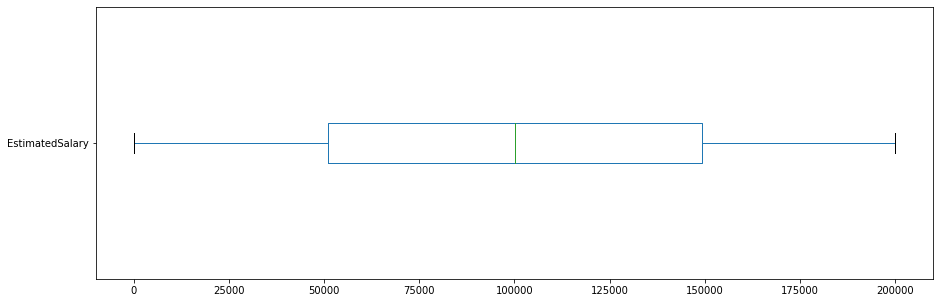

In [17]:
for i in numeric:
    df_ohe[i].plot(kind='box', vert=False, figsize=[15, 5])
    plt.show()

In [18]:
#выделяем целевой признак
target = df_ohe['Exited']
#выделяем признаки
features = df_ohe.drop(columns=['Exited'], axis=1)

In [19]:
#разделим выборку на обучающую и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

In [20]:
#нормируем данные
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

print(features_train.shape)
print(features_test.shape)

(7500, 11)
(2500, 11)


In [21]:
print(target[target==0].count())
print(target[target==1].count())

7963
2037


Объектов 1 класса гораздо меньше объектов 0 класса.

In [22]:
#обучим логистическую регрессию 
lgr = LogisticRegression(solver='liblinear', random_state=12345)
lgr.fit(features_train, target_train)
prediction = lgr.predict(features_test)
print('F1 =', f1_score(target_test, prediction))
print('ROC-AUC =', roc_auc_score(target_test, prediction))

F1 = 0.2948539638386648
ROC-AUC = 0.5792180923164728


In [23]:
#найдем оптимальные параметры для случайного леса
rfc = RandomForestClassifier()

parameters = {
    'n_estimators':range(10, 150, 20),
    'max_depth': range(1, 20, 5)
}
best_rfc = GridSearchCV(rfc, parameters)
best_rfc.fit(features_train, target_train)
best_rfc.best_params_

{'max_depth': 11, 'n_estimators': 30}

In [24]:
#обучим модель случайного леса с лучшими параметрами и посмотрим метрики
model_rfc = best_rfc.best_estimator_.fit(features_train, target_train)
prediction_test = model_rfc.predict(features_test)
print('F1 =', f1_score(target_test, prediction_test))
print('ROC-AUC =', roc_auc_score(target_test, prediction_test))

F1 = 0.562874251497006
ROC-AUC = 0.7030867280207367


In [25]:
#найдем оптимальные параметры для градиентного бустинга 
parameters = {
    'learning_rate':[0.1, 0.01],
    'n_estimators':[50, 100, 150],
    'max_depth':[3, 5 , 10, 20]
}
gbc = GradientBoostingClassifier(random_state=12345)
clf_gbc = GridSearchCV(gbc, parameters)
clf_gbc.fit(features_train, target_train)
    
    

GridSearchCV(estimator=GradientBoostingClassifier(random_state=12345),
             param_grid={'learning_rate': [0.1, 0.01],
                         'max_depth': [3, 5, 10, 20],
                         'n_estimators': [50, 100, 150]})

In [26]:
#обучим модель градиентного бустинга с лучшими параметрами и посмотрим метрики
best_gbc = clf_gbc.best_estimator_.fit(features_train, target_train)
prediction_test = best_gbc.predict(features_test)
print('F1 =', f1_score(target_test, prediction_test))
print('ROC-AUC =', roc_auc_score(target_test, prediction_test))

F1 = 0.5929411764705882
ROC-AUC = 0.7194834843404436


In [27]:
#рассчитаем оптимальный порог классификации для логистической регрессии
model = LogisticRegression(solver='liblinear', random_state=12345)
model.fit(features_train, target_train)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

for threshold in np.arange(0, 0.6, 0.05):
    predicted_test = probabilities_one_test > threshold
    precision = precision_score(target_test, predicted_test)
    recall = recall_score(target_test, predicted_test)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}, ROC_auc = {:.3f}".format(
        threshold, precision, recall, f1_score(target_test, predicted_test), roc_auc_score(target_test, predicted_test)))

Порог = 0.00 | Точность = 0.214, Полнота = 1.000, F1 = 0.353, ROC_auc = 0.500
Порог = 0.05 | Точность = 0.234, Полнота = 0.968, F1 = 0.377, ROC_auc = 0.553
Порог = 0.10 | Точность = 0.283, Полнота = 0.893, F1 = 0.429, ROC_auc = 0.638
Порог = 0.15 | Точность = 0.339, Полнота = 0.804, F1 = 0.476, ROC_auc = 0.688
Порог = 0.20 | Точность = 0.387, Полнота = 0.705, F1 = 0.499, ROC_auc = 0.700
Порог = 0.25 | Точность = 0.429, Полнота = 0.619, F1 = 0.507, ROC_auc = 0.697
Порог = 0.30 | Точность = 0.462, Полнота = 0.507, F1 = 0.483, ROC_auc = 0.673
Порог = 0.35 | Точность = 0.500, Полнота = 0.419, F1 = 0.456, ROC_auc = 0.652
Порог = 0.40 | Точность = 0.524, Полнота = 0.323, F1 = 0.400, ROC_auc = 0.622
Порог = 0.45 | Точность = 0.547, Полнота = 0.273, F1 = 0.364, ROC_auc = 0.606
Порог = 0.50 | Точность = 0.576, Полнота = 0.198, F1 = 0.295, ROC_auc = 0.579
Порог = 0.55 | Точность = 0.637, Полнота = 0.148, F1 = 0.240, ROC_auc = 0.562


In [28]:
#рассчитаем оптимальный порог классификации для градиентного бустинга
model = GradientBoostingClassifier(random_state=12345)
model.fit(features_train, target_train)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
for threshold in np.arange(0, 0.5, 0.05):
    predicted_test = probabilities_one_test > threshold
    precision = precision_score(target_test, predicted_test)
    recall = recall_score(target_test, predicted_test)
    print('Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}, ROC_auc = {:.3f}'.format(
    threshold, precision, recall, f1_score(target_test, predicted_test), roc_auc_score(target_test, predicted_test)))

Порог = 0.00 | Точность = 0.214, Полнота = 1.000, F1 = 0.353, ROC_auc = 0.500
Порог = 0.05 | Точность = 0.280, Полнота = 0.970, F1 = 0.435, ROC_auc = 0.646
Порог = 0.10 | Точность = 0.367, Полнота = 0.908, F1 = 0.523, ROC_auc = 0.741
Порог = 0.15 | Точность = 0.467, Полнота = 0.843, F1 = 0.601, ROC_auc = 0.790
Порог = 0.20 | Точность = 0.537, Полнота = 0.772, F1 = 0.633, ROC_auc = 0.795
Порог = 0.25 | Точность = 0.602, Полнота = 0.710, F1 = 0.652, ROC_auc = 0.791
Порог = 0.30 | Точность = 0.666, Полнота = 0.652, F1 = 0.659, ROC_auc = 0.782
Порог = 0.35 | Точность = 0.712, Полнота = 0.609, F1 = 0.657, ROC_auc = 0.771
Порог = 0.40 | Точность = 0.738, Полнота = 0.551, F1 = 0.631, ROC_auc = 0.749
Порог = 0.45 | Точность = 0.765, Полнота = 0.523, F1 = 0.622, ROC_auc = 0.740


Вывод:

Базовая модель логистической регрессии показала результат по f1 и roc_auc соответственно 0,29 и 0,57.

Модель случайного леса на тестовых данных f1 и roc_auc соответственно 0,56 и 0,70.

Модель градиентного бустинга на тестовых данных f1 и roc_auc соответственно 0,60 и 0,72.

При изменении порога классификации в логистической регрессии оптимальные значений метрик составляют F1 = 0.505, ROC_auc = 0.696 при пороге =0,25.

При изменении порога классификации градиентный бустинг на тестовых данных при пороге 0,25 дает результат 0,654 и 0,792. 

Таким образом лучший результат на текущих обучающих данных без борьбы с дисбалансом классов получены градиентным бустингом.

## Борьба с дисбалансом

In [29]:
features_zeros = features[target==0]
print(features_zeros.shape)
features_ones = features[target==1]
print(features_ones.shape)


(7963, 11)
(2037, 11)


Объектов отрицательного класса почти в четыре раза больше, чем объектов положительного класса. 

<b> Применение параметра class_weight 

In [30]:
#рассчитаем модель логистической регрессии с параметром class_weight = 'balanced'
model = LogisticRegression(random_state=12345, solver='liblinear',class_weight = 'balanced')
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))
print("ROC_auc:", roc_auc_score(target_test, predicted_test))

F1: 0.5050369375419745
ROC_auc: 0.7043280778102778


In [31]:
#рассчитаем оптимальный порог классификации для логистической регрессии с параметром class_weight = 'balanced'

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

for threshold in np.arange(0, 0.5, 0.05):
    predicted_test = probabilities_one_test > threshold 
    precision = precision_score(target_test,predicted_test) 
    recall = recall_score(target_test,predicted_test) 
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}, ROC_auc = {:.3f}".format(
        threshold, precision, recall, f1_score(target_test, predicted_test), roc_auc_score(target_test, predicted_test)))

Порог = 0.00 | Точность = 0.214, Полнота = 1.000, F1 = 0.353, ROC_auc = 0.500
Порог = 0.05 | Точность = 0.214, Полнота = 1.000, F1 = 0.353, ROC_auc = 0.501
Порог = 0.10 | Точность = 0.218, Полнота = 0.998, F1 = 0.358, ROC_auc = 0.513
Порог = 0.15 | Точность = 0.227, Полнота = 0.979, F1 = 0.368, ROC_auc = 0.536
Порог = 0.20 | Точность = 0.241, Полнота = 0.959, F1 = 0.386, ROC_auc = 0.569
Порог = 0.25 | Точность = 0.263, Полнота = 0.938, F1 = 0.411, ROC_auc = 0.611
Порог = 0.30 | Точность = 0.285, Полнота = 0.908, F1 = 0.434, ROC_auc = 0.644
Порог = 0.35 | Точность = 0.310, Полнота = 0.860, F1 = 0.455, ROC_auc = 0.669
Порог = 0.40 | Точность = 0.338, Полнота = 0.824, F1 = 0.480, ROC_auc = 0.693
Порог = 0.45 | Точность = 0.365, Полнота = 0.774, F1 = 0.496, ROC_auc = 0.704


In [32]:
#подберем оптимальные параметры для модели случайного леса с параметром class_weight = 'balanced'
parameters = {
    'n_estimators' : range(10, 150, 20),
    'max_depth':[5,10,20],    
    'class_weight' : ['balanced']
}

rfc = RandomForestClassifier(random_state=12345)

clf_rfc_b = GridSearchCV(
    estimator = rfc,
    param_grid = parameters)

clf_rfc_b.fit(features_train, target_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=12345),
             param_grid={'class_weight': ['balanced'], 'max_depth': [5, 10, 20],
                         'n_estimators': range(10, 150, 20)})

In [33]:
#обучим модель Случайного леса с лучшими гиперпараметрами и с параметром class_weight = 'balanced'. 
#рассчитаем метрики на тестовой выборке
model_rfc_b = clf_rfc_b.best_estimator_.fit(features_train, target_train)
predicted_test = model_rfc_b.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))
print("ROC_auc:", roc_auc_score(target_test, predicted_test))

F1: 0.5520581113801453
ROC_auc: 0.6970535777983876


In [34]:
#рассчитаем оптимальный порог классификации для случайного леса с параметром  class_weight = 'balanced'

probabilities_test = model_rfc_b.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

for threshold in np.arange(0, 0.5, 0.05):
    predicted_test = probabilities_one_test > threshold 
    precision = precision_score(target_test,predicted_test) 
    recall = recall_score(target_test,predicted_test) 
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}, ROC_auc = {:.3f}".format(
        threshold, precision, recall, f1_score(target_test, predicted_test), roc_auc_score(target_test, predicted_test)))

Порог = 0.00 | Точность = 0.226, Полнота = 0.998, F1 = 0.369, ROC_auc = 0.534
Порог = 0.05 | Точность = 0.292, Полнота = 0.948, F1 = 0.446, ROC_auc = 0.660
Порог = 0.10 | Точность = 0.362, Полнота = 0.890, F1 = 0.515, ROC_auc = 0.731
Порог = 0.15 | Точность = 0.417, Полнота = 0.832, F1 = 0.556, ROC_auc = 0.758
Порог = 0.20 | Точность = 0.491, Полнота = 0.764, F1 = 0.598, ROC_auc = 0.774
Порог = 0.25 | Точность = 0.554, Полнота = 0.703, F1 = 0.619, ROC_auc = 0.774
Порог = 0.30 | Точность = 0.611, Полнота = 0.645, F1 = 0.627, ROC_auc = 0.766
Порог = 0.35 | Точность = 0.672, Полнота = 0.602, F1 = 0.635, ROC_auc = 0.761
Порог = 0.40 | Точность = 0.728, Полнота = 0.535, F1 = 0.616, ROC_auc = 0.740
Порог = 0.45 | Точность = 0.750, Полнота = 0.471, F1 = 0.579, ROC_auc = 0.714


Вывод


При применении гиперпараметра class_weight = 'balanced' для борьбы с дисбалансом классов модель логистической регрессии показала результат на тестовой выборке по f1 0,50 и roc_auc 0,70, что значительно лучше, чем без данного гиперпараметра.


Модель случайного леса показала результат на тестовой выборке по f1 0,56 и roc_auc 0,70. Результат по метрикам случайного леса такой же как и без применения гиперпараметра class_weight = 'balanced'


При изменении порога модель случайного леса показала лучшей результат при пороге равном 0,35 f1 0,632 и roc_auc 0,758

<b> Увеличение выборки (upsampling)

In [35]:
#cоздадим функцию,которая принимает на вход : датафрейм признаков, целевые значения, количество раз,
#в которое необходимо увеличить меньший класс, что бы выборка стала сбалансированной
#результат функции : увеличенная исходная выборка со сбалансированными классами: датафрейм признаков и целевые значения
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)    
    return features_upsampled, target_upsampled

In [36]:
# признаки и целевое значение увеличенной обучающей выборки 
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [37]:
#на увеличенной выборке обучим логистическую регрессию
model = LogisticRegression(random_state=12345,solver='liblinear')
model.fit(features_upsampled,target_upsampled)
predicted_test = model.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))
print("ROC_auc:", roc_auc_score(target_test, predicted_test))

F1: 0.5050369375419745
ROC_auc: 0.7043280778102778


In [38]:
#подберем оптимальные параметры для модели случайного леса по увеличенной сбалансированной выборке
parameters = {
    'n_estimators' : range(10, 200, 20),
    'max_depth':[5,10,20]    
}

rfc = RandomForestClassifier(random_state=12345)

clf_rfc_upsampled = GridSearchCV(
    estimator = rfc,
    param_grid = parameters)

clf_rfc_upsampled.fit(features_upsampled, target_upsampled)

GridSearchCV(estimator=RandomForestClassifier(random_state=12345),
             param_grid={'max_depth': [5, 10, 20],
                         'n_estimators': range(10, 200, 20)})

In [39]:
#обучим модель Случайного леса с лучшими гиперпараметрами по увеличенной сбалансированной выборке. 
#рассчитаем метрики на тестовой выборке
model_rfc_upsampled = clf_rfc_upsampled.best_estimator_.fit(features_upsampled, target_upsampled)
predicted_test = model_rfc_upsampled.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))
print("ROC_auc:", roc_auc_score(target_test, predicted_test))

F1: 0.6160164271047228
ROC_auc: 0.7450048750326984


In [40]:
#подберем оптимальные параметры для модели Градиентного бустинга по увеличенной сбалансированной выборке
parameters = {
    'learning_rate' : [0.1, 0.01],
    'n_estimators' : [50, 100, 150],
    'max_depth':[3,5,10,20],
}

gbc = GradientBoostingClassifier(random_state=12345)

clf_gbc_upsampled = GridSearchCV(
    estimator = gbc,
    param_grid = parameters)
    
clf_gbc_upsampled.fit(features_upsampled, target_upsampled)

GridSearchCV(estimator=GradientBoostingClassifier(random_state=12345),
             param_grid={'learning_rate': [0.1, 0.01],
                         'max_depth': [3, 5, 10, 20],
                         'n_estimators': [50, 100, 150]})

In [41]:
#обучим модель Градиентного бустинга с лучшими гиперпараметрами по увеличенной сбалансированной выборке. 
#рассчитаем метрики на тестовой выборке
model_gbc_upsampled = clf_gbc_upsampled.best_estimator_.fit(features_upsampled, target_upsampled)
predicted_test = model_gbc_upsampled.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))
print("ROC_auc:", roc_auc_score(target_test, predicted_test))

F1: 0.6025641025641026
ROC_auc: 0.7332715036503293


Вывод
При увеличении выбоки для борьбы с дисбалансом классов метрики логистической регресси f1 и roc_auc составили соответственно 0,50 и 0,70 
, данный результат полностью соответствует результату, полученному при применении гиперпараметра class_weight = 'balanced' для логистической регрессии.


При увеличении выбоки для борьбы с дисбалансом классов метрики случайного леса на тестовых данных f1 и roc_auc составили соответственно 0,61 и 0,74 ,
данный результат лучше результата, полученного при применении гиперпараметра class_weight = 'balanced' для случайного леса(0,56 и 0,70 соответственно).


Градиентный бустинг, обученный на увеличенной выборке, показал на тестовых данных результат по f1 и roc_auc соответственно 0,60 и 0,73, 
что незначительно лучше результата по градиентному бустингу, обученному на первоначальном датафрейме (с дисбалансом классов).

<b> Уменьшение выборки (downsampling)

In [43]:
#создадим функцию,которая принимает на вход : датафрейм признаков, целевые значения, долю
#более многочисленного класса, что бы выборка стала сбалансированной
#результат функции : уменьшена исходная выборка со сбалансированными классами: датафрейм признаков и целевые значения
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)    
    return features_downsampled, target_downsampled

In [44]:
#признаки и целевое значение уменьшенной обучающей выборки
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

In [45]:
#обучим модель логистической регрессии по увеличенной выборке и посчитаем метрики 
model = LogisticRegression(random_state = 12345, solver = 'liblinear')
model.fit(features_downsampled,target_downsampled)
predicted_test = model.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))
print("ROC_auc:", roc_auc_score(target_test, predicted_test))

F1: 0.5100133511348465
ROC_auc: 0.7091721956671662


In [46]:
#подберем оптимальные параметры для модели случайного леса по уменьшенной сбалансированной выборке
parameters = {
    'n_estimators' : range(10, 200, 20),
    'max_depth':[5,10,20],
}

rfc = RandomForestClassifier(random_state=12345)

clf_rfc_downsampled = GridSearchCV(
    estimator = rfc,
    param_grid = parameters)

clf_rfc_downsampled.fit(features_downsampled,target_downsampled)

GridSearchCV(estimator=RandomForestClassifier(random_state=12345),
             param_grid={'max_depth': [5, 10, 20],
                         'n_estimators': range(10, 200, 20)})

In [47]:
#обучим модель случайного леса с лучшими гиперпараметрами по уменьшенной выборке. 
#рассчитаем метрики на тестовой выборке
model_rfc_downsampled = clf_rfc_downsampled.best_estimator_.fit(features_downsampled,target_downsampled)
predicted_test = model_rfc_downsampled.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))
print("ROC_auc:", roc_auc_score(target_test, predicted_test))

F1: 0.6193265007320645
ROC_auc: 0.7915103089106087


In [48]:
#подберем оптимальные параметры для модели Градиентного бустинга по уменьшенной сбалансированной выборке
parameters = {
    'learning_rate' : [0.1, 0.01],
    'n_estimators' : [50, 100, 150],
    'max_depth':[3,5,10,20],
}

gbc = GradientBoostingClassifier(random_state=12345)

clf_gbc_downsampled = GridSearchCV(
    estimator = gbc,
    param_grid = parameters,
    cv=3
)
    
clf_gbc_downsampled.fit(features_downsampled,target_downsampled)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=12345),
             param_grid={'learning_rate': [0.1, 0.01],
                         'max_depth': [3, 5, 10, 20],
                         'n_estimators': [50, 100, 150]})

In [49]:
#обучим модель Градиентного бустинга с лучшими гиперпараметрами по уменьшенной сбалансированной выборке. 
#рассчитаем метрики на тестовой выборке
model_gbc_downsampled = clf_gbc_downsampled.best_estimator_.fit(features_downsampled,target_downsampled)
predicted_test = model_gbc_downsampled.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))
print("ROC_auc:", roc_auc_score(target_test, predicted_test))

F1: 0.6156111929307806
ROC_auc: 0.7876007704929728


Вывод


При уменьшении выбоки для борьбы с дисбалансом классов метрики логистической регресси f1 и roc_auc составили соответственно 0,51 и 0,71 , данный результат полностью соответствует результатам, полученным при применении гиперпараметра class_weight = 'balanced' и при применении метода увеличения обучающей выборки для логистической регрессии.


При уменьшении выбоки для борьбы с дисбалансом классов метрики случайного леса на тестовых данных f1 и roc_auc составили соответственно 0,62 и 0,79 , данный результат незначительно хуже по параметру f1 и лучше по параметру roc_auc, полученному при применении гиперпараметра class_weight = 'balanced' для случайного леса(0,64 и 0,78 соответственно).


Градиентный бустинг, обученный на уменьшенной выборке, показал на тестовых данных результат по f1 и roc_auc соответственно 0,61 и 0,78.

## Тестирование модели

Создадим константную модель: любому объекту она прогнозирует класс «1».

In [52]:
target_constant = pd.Series(data = 1, index=range(len(target)))

In [53]:
print("precision:", precision_score(target, target_constant))
print("recall:", recall_score(target, target_constant))
print("F1:", f1_score(target, target_constant))
print("ROC_auc:", roc_auc_score(target, target_constant))
print("accuracy:", accuracy_score(target, target_constant))

precision: 0.2037
recall: 1.0
F1: 0.3384564260197724
ROC_auc: 0.5
accuracy: 0.2037


Хорошая модель, полученная для данного датафрейма , это модель градиентного бустинга, обученного на уменьшенной выборке. 

Очень хорошие результаты показало изменение порога для модели градиентного бустинга без учета дисбалансов классов: на тестовых данных при пороге 0,25 дает результат 0,654 и 0,792. 


При изменении порога модель случайного леса показала лучший результат при пороге равном 0,35 f1 0,632 и roc_auc 0,758